## Test with SIPPY Package

https://github.com/CPCLAB-UNIPI/SIPPY

Installation: 
* Ensure `numpy`, `scipy`, `control`, `slycot`, `future` have been installed. (Use `pip install <package name>`)
* `git clone https://github.com/CPCLAB-UNIPI/SIPPY.git`
* `cd SIPPY`
* `python3 setup.py install`

Notes: resulting matrices not in observable canonical form (for state feedback)

In [1]:
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
import sippy as si
import control as ctrl
from sippy import functionsetSIM as fsetSIM

In [2]:
filename = 'PI_Server_Out_2019-10-16_141348.846364-modelID.csv'
# data columns
# 2->Ts, 15->q, 23->P, 26->Is
data = pd.read_csv(filename, usecols=[2,15,23,26])
osc_data = pd.read_csv(filename, usecols=[6,7]).to_numpy()
data = data.to_numpy()
# print(osc_data)

# remove last few rows (time ponts) when the experiment stopped
data = data[:-20, :]

# normalize intensity to make it of the same order of magnitude as T
udata = np.vstack((data[:,1], data[:,2])) # [q; P]
ydata = np.vstack((data[:,0], data[:,3])) # [Ts; Is]
ydata[1,:] = ydata[1,:]/10

# Exclude nonlinear region (at the end)
udata = udata[:, 99:]
ydata = ydata[:, 99:]
# print(udata.shape)

Cleaning data...
Input Steady States:  [2.    1.978]
Output Steady States:  [37.032  6.36 ]
Estimated Error Norm:  0.7839936786897227
Modifying identified system to have state feedback...
Plotting comparison between data and identified linear model...


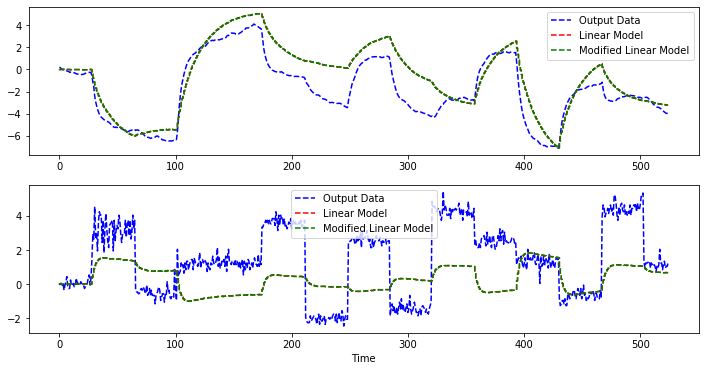

Maximum Error:  [1.80621045 4.68088926]
Minimum Error:  [-3.79316842 -2.47058832]


In [4]:
def modelID(udata, ydata, Ts=1, IDmethod='N4SID', modelOrder=2, plot=True):
    '''
    wrapper function to identify a model using data using the SIPPY package (https://github.com/CPCLAB-UNIPI/SIPPY)
    
    udata    is the input data (shape nu x N, where N is is the number of samples and nu is the number of inputs)
    ydata    is the output data (shape ny x N, where N is is the number of samples and ny is the number of outputs)
    Ts       is the sampling time for the data
    IDmethod is the method used for system identification, default is N4SID, see SIPPY documentation for more details
    modelOrder is the model order for the identified system, default is 2
    plot     is whether or not to plot a visual comparison of the identified model with the experimental data
    
    returns (A, B, C, D, uss, yss, maxErrors, minErrors)
    Process Form with no disturbance model
    x(k+1) = A@x + B@u
    y = C@x + D@u
    '''
    
    print('Cleaning data...')
    # center data
    uss = np.mean(udata[:,:10], axis=1).reshape(-1,1)
    yss = np.mean(ydata[:,:10], axis=1).reshape(-1,1)
    udataC = udata-uss
    ydataC = ydata-yss
    
    print('Input Steady States: ', np.ravel(uss))
    print('Output Steady States: ', np.ravel(yss))
    
    # subspace identification
    # TODO: perform some kind of optimization for SS_f and SS_p (future and past horizon to use)
    est_errors = np.inf*np.ones((10,10))
    for ss_f in range(modelOrder,10):
        for ss_p in range(modelOrder,10):
            sys = si.system_identification(ydataC, udataC, IDmethod, SS_f=ss_f, SS_p=ss_p, 
                                           SS_fixed_order=modelOrder, tsample=Ts)
            est_errors[ss_f,ss_p] = sys.Vn
            
    best_SS_f, best_SS_p = np.unravel_index(np.argmin(est_errors, axis=None), est_errors.shape)
    sys = si.system_identification(ydataC, udataC, IDmethod, SS_f=int(best_SS_f), SS_p=int(best_SS_p), 
                                   SS_fixed_order=modelOrder, tsample=Ts)
#     sys = si.system_identification(ydataC, udataC, IDmethod, SS_fixed_order=modelOrder, tsample=Ts)
    est_error = sys.Vn
    print('Estimated Error Norm: ', est_error)
    
    A = sys.A
    B = sys.B
    C = sys.C
    D = sys.D
    
    nx, nu = B.shape
    ny, _ = C.shape
    x0 = np.zeros((nx, 1))
    xPred, yPred = fsetSIM.SS_lsim_process_form(A,B,C,D,udataC,x0)
    
#     sys = ctrl.canonical_form(sys.G, 'observable') # not compatible yet...
    # modify identified system to be state feedback
    print('Modifying identified system to have state feedback...')
    try:
        Cinv = np.linalg.inv(C)
    except np.linalg.LinAlgError:
        print('Inverse of C could not be found. A state feedback representation could not be obtained.')
        pass
    else:
        Amod = C@A@Cinv
        Bmod = C@B
        Cmod = C@Cinv
        if np.allclose(Cmod, np.eye(ny)):
            Cmod = np.eye(ny)
    
    n = udata.shape[1]
    
    xest, yest = fsetSIM.SS_lsim_process_form(Amod,Bmod,Cmod,D,udataC,x0)
    
    if plot:
        print('Plotting comparison between data and identified linear model...')
        t = np.arange(n)*Ts
        ny = ydata.shape[0]
        
        fig = plt.figure(figsize=(12,6))
        labels = ['Output Data', 'Linear Model', 'Modified Linear Model']
        for i in range(ny):
            ax = fig.add_subplot(ny,1,i+1)
            ax.plot(t, ydataC[i,:], 'b--', label=labels[0])     
            ax.step(t, yPred[i,:], 'r--', label=labels[1])
            ax.step(t, yest[i,:], 'g--', label=labels[2])
            plt.legend()
        plt.xlabel('Time')
        plt.show()
        
    maxErrors = np.max(ydataC-yPred, axis=1)
    print('Maximum Error: ', maxErrors)
    minErrors = np.min(ydataC-yPred, axis=1)
    print('Minimum Error: ', minErrors)
    
    return Amod, Bmod, Cmod, D, uss, yss, maxErrors, minErrors

A, B, C, D, uss, yss, maxErrors, minErrors = modelID(udata, ydata, IDmethod='CVA', Ts=0.8)

In [4]:
print(A)
print(B)
print(C)
print(D)

[[ 0.98708953  0.32984357]
 [-0.00558122  0.82044615]]
[[-0.25601379  0.2454256 ]
 [ 0.09417257 -0.08256473]]
[[1. 0.]
 [0. 1.]]
[[0. 0.]
 [0. 0.]]


## Test with another dataset

In [20]:
# USER INPUTS
filename = '2020_12_07_17h05m08s_systemIdentOutputs.csv'
# data rows
# 1->Ts, 2->Is, 3->P, 4->q
uidxs = [2,3]
yidxs = [0,1]

# labels corresponding to the data
y_labels = ['T ($^\circ$ C)', 'I (a.u.)']
u_labels = ['P (W)', 'q (slm)']

Ts = 1; # Sampling time

norm_intensity = True; # True for yes, False for no
I_col = 1; # column/row in which the intensity data is located, leave as 
# empty if not specified
plot_fit = True; # True for yes, False for no; plot a comparison of the data 
# and identified model

saveModel = True; # True for yes, False for no

out_filename = [];

[[ 28.95        29.01        29.07        47.23        45.73
   44.82        44.76        44.86        45.23        45.32
   45.31        46.07        45.92        45.79        46.26
   46.38        46.37        46.67        46.73        46.86
   47.55        47.64        47.6         47.62        47.87
   48.86        49.13        48.93        48.19        48.13      ]
 [130.23068389 130.31747096 130.48589591 131.71374094 131.83301464
  131.53595385 131.6480187  131.39074701 131.56563184 131.52593636
  131.51245487 131.45422234 131.62929441 131.69202077 131.50786742
  131.63397549 131.48464931 131.72123066 131.90173277 131.59371827
  131.53689006 131.43690238 132.07998797 131.52930673 131.43559168
  131.37314619 131.49344972 131.49148367 131.64661438 131.60270593]
 [  1.5          1.5          1.5          1.5          1.5
    1.5          1.5          1.5          1.5          1.5
    1.5          1.5          1.5          1.5          1.5
    1.5          1.5          1.5          1

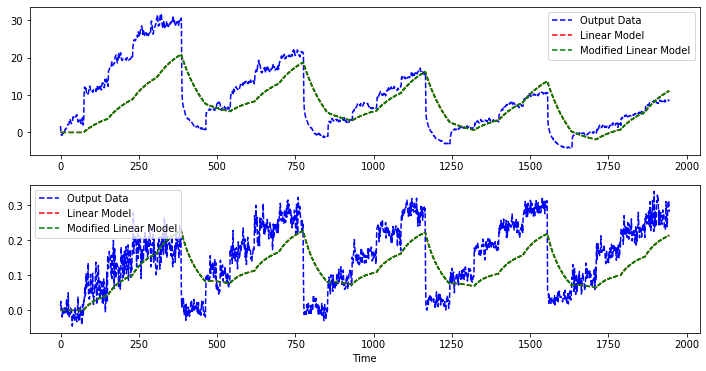

Maximum Error:  [16.89200532  0.18179396]
Minimum Error:  [-12.97636219  -0.22920107]


In [19]:
# CLEAN DATA
# load data
data = np.genfromtxt(filename, delimiter=',')

# remove startup values
# print(data[:, :30])
data = data[:, 3:]
# print(data[:, :30])

# normalize intensity to make it of the same order of magnitude as T
data[I_col,:] = data[I_col,:]/10

# stack/split data as specified by indices
udata = data[uidxs,:]
ydata = data[yidxs,:]
# print(udata.shape)

A, B, C, D, uss, yss, maxErrors, minErrors = modelID(udata, ydata, IDmethod='CVA', Ts=Ts)

----

## Test with sysid package

https://github.com/jgoppert/sysid

Can be installed using `pip install sysid`

Notes: cannot choose model order, cannot set D = 0

Steady States:  {'uss': array([2.   , 1.978]), 'yss': array([37.032,  6.36 ])}
(9, 9)


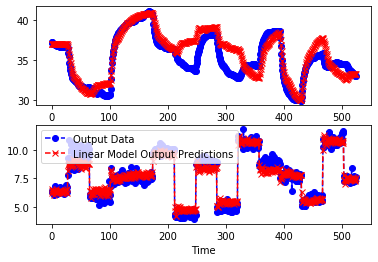

Maximum Error:  [2.38677814 2.05682688]
Minimum Error:  [-3.87065618 -1.26266304]


In [5]:
import sysid

def modelID(udata, ydata, Ts=1, modelOrder=2, plot=True):
    '''
    wrapper function to identify a model using data using the sysid package (https://github.com/jgoppert/sysid)
    
    udata    is the input data (shape nu X N, where N is is the number of samples and nu is the number of inputs)
    ydata    is the output data (shape ny x N, where N is is the number of samples and ny is the number of outputs)
    Ts       is the sampling time for the data
    modelOrder is the model order for the identified system, default is 2
    plot     is whether or not to plot a visual comparison of the identified model with the experimental data
    
    returns (A, B, C, D, steadyStates, maxErrors, minErros)
    Process Form with no disturbance model
    x(k+1) = A@x + B@u
    y = C@x + D@u
    '''
    # center data
    uss = np.mean(udata[:,:10], axis=1).reshape(-1,1)
    yss = np.mean(ydata[:,:10], axis=1).reshape(-1,1)
    udataC = udata-uss
    ydataC = ydata-yss
    
    steadyStates = {'uss': np.ravel(uss),
                    'yss': np.ravel(yss)}
    print('Steady States: ', steadyStates)
    
    # subspace identification
    sys = sysid.subspace_det_algo1(y=ydataC, u=udataC, dt=Ts, f=3, p=8, s_tol=0.01)
    
    A = sys.A
    B = sys.B
    C = sys.C
    D = sys.D
    print(A.shape)
#     sys = ctrl.canonical_form(sys.G, 'observable') # not compatible yet...
    
    n = udata.shape[1]
    xPred, yPred = fsetSIM.SS_lsim_process_form(A,B,C,D,udataC)
    
    if plot:
        t = np.arange(n)*Ts
        ny = ydata.shape[0]
        
        fig = plt.figure()
        for i in range(ny):
            ax = fig.add_subplot(ny,1,i+1)
            if i == ny-1:
                label1 = 'Output Data'
                label2 = 'Linear Model Output Predictions'
            else:
                label1=''
                label2=''
            ax.plot(t, ydata[i,:], 'bo--', label=label1)
            ax.plot(t, yPred[i,:]+yss[i], 'rx--', label=label2)
        plt.legend()
        plt.xlabel('Time')
        plt.show()
        
    maxErrors = np.max(ydata-yss-yPred, axis=1)
    print('Maximum Error: ', maxErrors)
    minErrors = np.min(ydata-yss-yPred, axis=1)
    print('Minimum Error: ', minErrors)
    
    return A, B, C, D, steadyStates, maxErrors, minErrors

A, B, C, D, steadyStates, maxErrors, minErrors = modelID(udata, ydata, Ts=0.8)

In [6]:
print(A)
print(B)
print(C)
print(D)

[[ 0.97183602  0.01016275 -0.06673787  0.08239823 -0.00099468 -0.01180877
   0.00292531 -0.07023701 -0.01099123]
 [ 0.03921603  0.82832924 -0.05929838 -0.10387327  0.06607287  0.04994752
   0.02268916 -0.12609237  0.09059124]
 [-0.00901937  0.3345628   0.66561688 -0.14752348  0.23985309  0.07635168
   0.04564222  0.47857149  0.04385061]
 [-0.15316484  0.3827394  -0.18309824  0.65168474  0.43273031  0.12889556
   0.10455219 -0.01480064 -0.35063149]
 [-0.14016764  0.52450759 -0.45105299 -0.46917881  0.15074389 -0.57529905
  -0.02431497  0.37572444 -0.34433842]
 [ 0.1138588  -0.40964118  0.23482286  0.17251154  0.57994808 -0.44792024
  -0.48655802 -0.35704802  0.25419936]
 [-0.07044149  0.26180681 -0.17017734 -0.13615713 -0.1156597   0.43933471
  -0.83919699  0.19102628 -0.16146556]
 [ 0.02408382  0.01439776 -0.10493873  0.04713306  0.11246077  0.04637864
   0.01993625  0.92795499  0.00883978]
 [ 0.071615    0.02810872 -0.16991578  0.14342342 -0.07594761 -0.08320336
  -0.03742458  0.01780